In [ ]:
!pip install meteostat pandas matplotlib



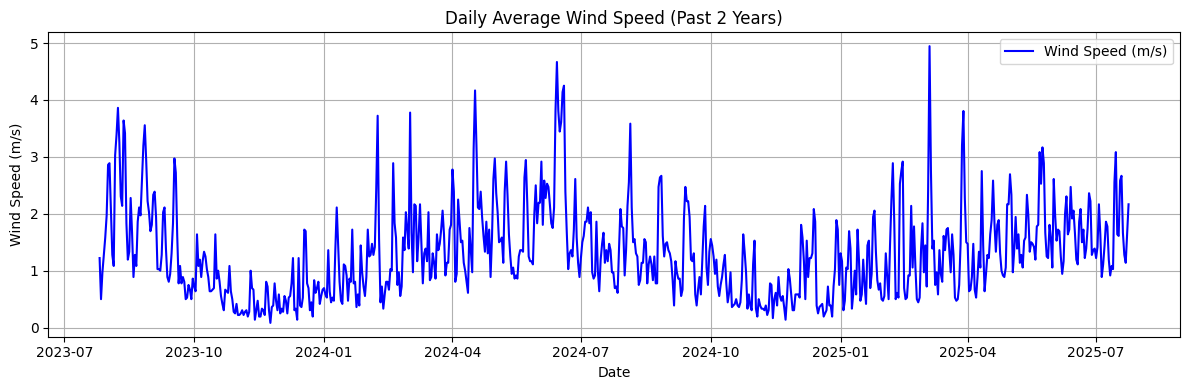

In [ ]:
from datetime import datetime, timedelta
from meteostat import Point, Daily
import pandas as pd
import matplotlib.pyplot as plt

# ---------- USER INPUT SECTION ----------
# Example: Chennai
latitude = 28.6139   # New Delhi
longitude = 77.2090


# Define the location
location = Point(latitude, longitude)

# Date range
start = datetime.now() - timedelta(days=730)  # last 2 years
end = datetime.now()

# ---------- FETCH DATA ----------
data = Daily(location, start, end)
data = data.fetch()

# ---------- FILTER ONLY WIND DATA ----------
# Wind Speed is in km/h in Meteostat; convert to m/s
data['wspd_mps'] = data['wspd'] * 1000 / 3600

# Save to CSV (will appear in file panel)
data.to_csv('wind_data_chennai.csv')

# ---------- PLOT ----------
plt.figure(figsize=(12, 4))
plt.plot(data.index, data['wspd_mps'], label='Wind Speed (m/s)', color='blue')
plt.title('Daily Average Wind Speed (Past 2 Years)')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
from google.colab import files
files.download('wind_data_chennai.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

# Load city list from CSV
df_cities = pd.read_csv('CityLocations.csv')

# Preview it
df_cities.head()


,City,Latitude,Longitude
0,Delhi,28.6139,77.2090
1,Mumbai,19.0760,72.8777
2,Bangalore,12.9716,77.5946
3,Hyderabad,17.3850,78.4867
4,Ahmedabad,23.0225,72.5714


In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Create dropdown using city names
city_dropdown = widgets.Dropdown(
    options=df_cities['City'].tolist(),
    description='Select City:',
    style={'description_width': 'initial'}
)

display(city_dropdown)


Dropdown(description='Select City:', options=('Delhi', 'Mumbai', 'Bangalore', 'Hyderabad', 'Ahmedabad', 'Chenn…

In [ ]:
def get_coordinates(city_name):
    row = df_cities[df_cities['City'] == city_name].iloc[0]
    return row['Latitude'], row['Longitude']


In [ ]:
from datetime import datetime, timedelta
from meteostat import Point, Daily
import matplotlib.pyplot as plt

def fetch_wind_data(city_name):
    # Get lat/lon from CSV
    lat, lon = get_coordinates(city_name)

    # Meteostat location
    location = Point(lat, lon)
    start = datetime.now() - timedelta(days=730)
    end = datetime.now()

    # Fetch and process data
    data = Daily(location, start, end).fetch()
    data['wspd_mps'] = data['wspd'] * 1000 / 3600

    # Save CSV
    filename = f'wind_data_{city_name}.csv'
    data.to_csv(filename)

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(data.index, data['wspd_mps'], label='Wind Speed (m/s)', color='green')
    plt.title(f'Daily Wind Speed in {city_name}')
    plt.xlabel('Date')
    plt.ylabel('Wind Speed (m/s)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return filename


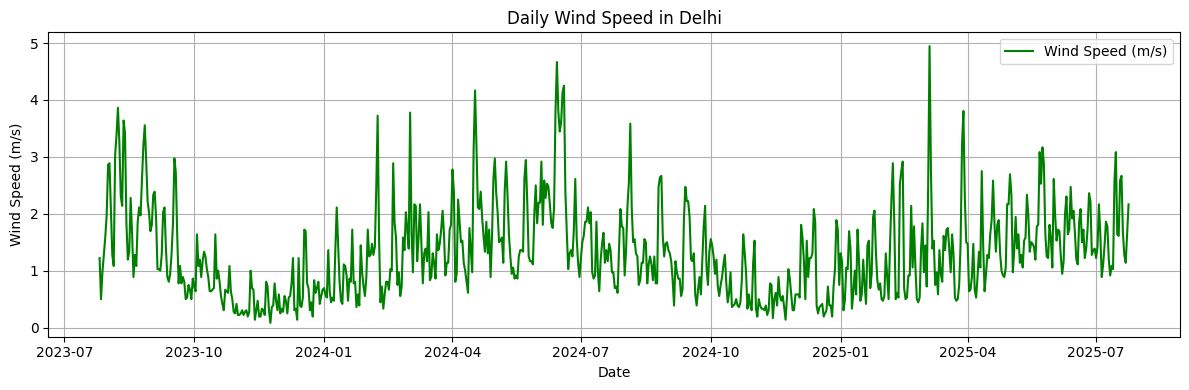

'wind_data_Delhi.csv'

In [ ]:
selected_city = city_dropdown.value
fetch_wind_data(selected_city)


In [ ]:
!pip install prophet


In [ ]:
from prophet import Prophet


In [ ]:
# Use the data from your previous step (daily wind data)
# We'll use the 'wspd_mps' column for forecasting

df_prophet = data[['wspd_mps']].reset_index()
df_prophet.columns = ['ds', 'y']

# Drop rows with missing values (if any)
df_prophet = df_prophet.dropna()

# Preview the formatted data
df_prophet.head()


,ds,y
0,2023-07-26,1.222222
1,2023-07-27,0.5
2,2023-07-28,0.972222
3,2023-07-29,1.277778
4,2023-07-30,1.583333


In [ ]:
# Step 1: Initialize Prophet model
model = Prophet(daily_seasonality=True)

# Step 2: Fit the model to your wind speed data
model.fit(df_prophet)

# Step 3: Create future dates (next 30 days)
future = model.make_future_dataframe(periods=30)

# Step 4: Make predictions
forecast = model.predict(future)

# Step 5: Preview the forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp773q2ug_/edon0v2i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp773q2ug_/fpqvhwsg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29036', 'data', 'file=/tmp/tmp773q2ug_/edon0v2i.json', 'init=/tmp/tmp773q2ug_/fpqvhwsg.json', 'output', 'file=/tmp/tmp773q2ug_/prophet_modelzhxrtp0b/prophet_model-20250724082350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:23:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:23:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
750,2025-08-14,1.893131,0.943885,2.807867
751,2025-08-15,1.866081,0.936277,2.759016
752,2025-08-16,1.802162,0.890611,2.671866
753,2025-08-17,1.762550,0.862774,2.684913
754,2025-08-18,1.817251,0.880593,2.665803
755,2025-08-19,1.820621,0.991206,2.737149
756,2025-08-20,1.866485,0.967187,2.820197
757,2025-08-21,1.916417,1.053681,2.836556
758,2025-08-22,1.889367,0.951215,2.722053
759,2025-08-23,1.825448,0.937199,2.726315


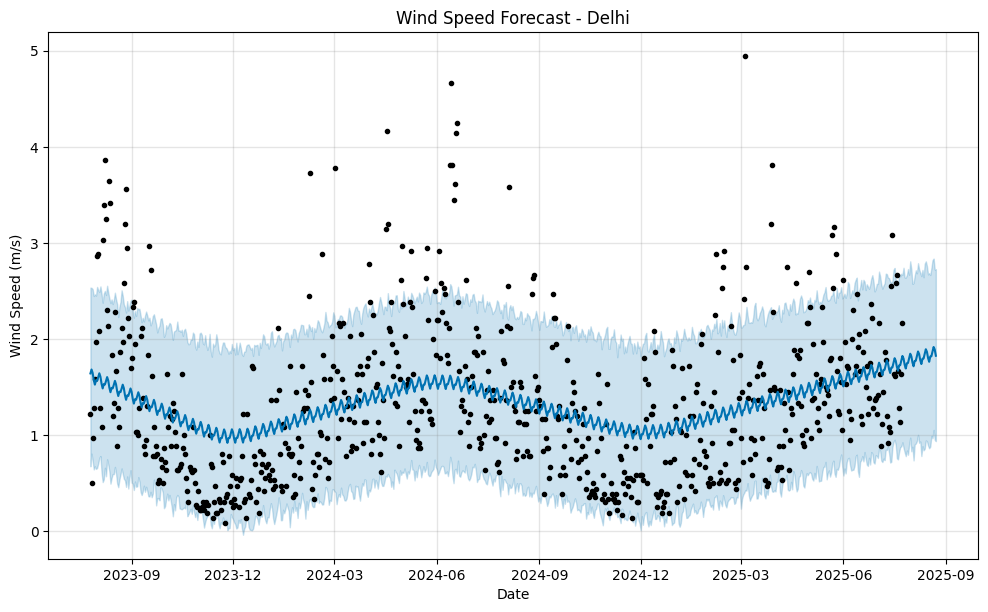

In [ ]:
# Plot the forecast
model.plot(forecast)
plt.title(f"Wind Speed Forecast - {selected_city}")
plt.xlabel("Date")
plt.ylabel("Wind Speed (m/s)")
plt.grid(True)
plt.show()


In [ ]:
# Keep only useful columns
forecast_result = forecast[['ds', 'yhat']]
forecast_result.columns = ['Date', 'Forecasted_WindSpeed_mps']

# Save to CSV
filename = f"forecast_{selected_city}.csv"
forecast_result.to_csv(filename, index=False)

# Optional: download the file
from google.colab import files
files.download(filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import requests
import pandas as pd
from datetime import date, timedelta

def get_open_meteo_historical_wind(lat, lon, start_date, end_date):
    base_url = "https://archive-api.open-meteo.com/v1/archive"

    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "daily": "windspeed_10m_max",
        "timezone": "auto"
    }

    response = requests.get(base_url, params=params)

    if response.status_code != 200:
        print(f"❌ Error fetching data: {response.status_code}")
        return pd.DataFrame()

    data = response.json()

    if "daily" in data and "time" in data["daily"]:
        df = pd.DataFrame({
            'date': data["daily"]["time"],
            'wind_speed_mps': data["daily"]["windspeed_10m_max"]
        })
        return df
    else:
        print("❌ No data returned for:", lat, lon)
        return pd.DataFrame()

# Example: Chennai
lat = 13.0827
lon = 80.2707

end_date = date.today()
start_date = end_date - timedelta(days=365)

df_chennai = get_open_meteo_historical_wind(lat, lon, start_date.isoformat(), end_date.isoformat())

# Show results
df_chennai.head()


,date,wind_speed_mps
0,2024-07-24,28.9
1,2024-07-25,30.3
2,2024-07-26,27.8
3,2024-07-27,30.4
4,2024-07-28,26.6


In [ ]:
# Load your city location file
city_df = pd.read_csv('/content/CityLocations.csv')  # Update the path if needed
city_df.head()


,City,Latitude,Longitude
0,Delhi,28.6139,77.2090
1,Mumbai,19.0760,72.8777
2,Bangalore,12.9716,77.5946
3,Hyderabad,17.3850,78.4867
4,Ahmedabad,23.0225,72.5714


In [ ]:
from datetime import date, timedelta

end_date = date.today()
start_date = end_date - timedelta(days=365)


In [ ]:
all_data = []

for idx, row in city_df.iterrows():
    city = row['City']
    lat = row['Latitude']
    lon = row['Longitude']

    print(f"📍 Fetching data for {city} ({lat}, {lon}) ...")

    df = get_open_meteo_historical_wind(lat, lon, start_date.isoformat(), end_date.isoformat())

    if not df.empty:
        df['City'] = city
        df['Latitude'] = lat
        df['Longitude'] = lon
        all_data.append(df)
    else:
        print(f"⚠️ No data for {city}")

# Combine all city data into a single DataFrame
all_wind_data = pd.concat(all_data, ignore_index=True)


📍 Fetching data for Delhi (28.6139, 77.209) ...
📍 Fetching data for Mumbai (19.076, 72.8777) ...
📍 Fetching data for Bangalore (12.9716, 77.5946) ...
📍 Fetching data for Hyderabad (17.385, 78.4867) ...
📍 Fetching data for Ahmedabad (23.0225, 72.5714) ...
📍 Fetching data for Chennai (13.0827, 80.2707) ...
📍 Fetching data for Kolkata (22.5726, 88.3639) ...
📍 Fetching data for Pune (18.5204, 73.8567) ...
📍 Fetching data for Jaipur (26.9124, 75.7873) ...
📍 Fetching data for Lucknow (26.8467, 80.9462) ...
📍 Fetching data for Kanpur (26.4499, 80.3319) ...
📍 Fetching data for Nagpur (21.1458, 79.0882) ...
📍 Fetching data for Indore (22.7196, 75.8577) ...
📍 Fetching data for Thane (19.2183, 72.9781) ...
📍 Fetching data for Bhopal (23.2599, 77.4126) ...
📍 Fetching data for Visakhapatnam (17.6868, 83.2185) ...
📍 Fetching data for Patna (25.5941, 85.1376) ...
📍 Fetching data for Vadodara (22.3072, 73.1812) ...
📍 Fetching data for Ghaziabad (28.6692, 77.4538) ...
📍 Fetching data for Ludhiana (30.9

In [ ]:
all_wind_data.to_csv('All_Cities_Wind_Data.csv', index=False)
print("✅ Wind data saved to All_Cities_Wind_Data.csv")


✅ Wind data saved to All_Cities_Wind_Data.csv


In [ ]:
from google.colab import files
files.download('All_Cities_Wind_Data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>